In [2]:
import numpy as np
import gym

import typing
import quadruped_gym.gym
from quadruped_gym.core.types import RobotObservation
from quadruped_gym.gym.env_builder import A1BulletGymEnv
from quadruped_gym.quadruped import a1_pybullet
from quadruped_gym.quadruped.a1_pybullet.simulator import SimulationParameters  # noqa: F401

class Logger:

    def __init__(self):
        self.data = []

    def update(self, data: typing.Union[np.ndarray, RobotObservation]):
        self.data.append(data)

    def collate(self):
        if isinstance(self.data[0], np.ndarray):
            all_data = np.stack(self.data, axis=0)
        else:
            all_data = RobotObservation(
                base_position = np.stack([obs.base_position for obs in self.data]),
                base_velocity = np.stack([obs.base_velocity for obs in self.data]),
                base_orientation = np.stack([obs.base_orientation for obs in self.data]),
                base_rpy = np.stack([obs.base_rpy for obs in self.data]),
                base_rpy_rate = np.stack([obs.base_rpy_rate for obs in self.data]),
                motor_angles = np.stack([obs.motor_angles for obs in self.data]),
                motor_velocities = np.stack([obs.motor_velocities for obs in self.data]),
                motor_torques = np.stack([obs.motor_torques for obs in self.data]),
            )
        return all_data

class Controller:
    
    def get_action(self, time_step: int):
        pass     

def test_simulation_with_controller(simulator, controller, n_time_steps = 100, n_action_repeat = 30):
    obs_logger = Logger()
    act_logger = Logger()

    obs = simulator.reset()
    for i in range(n_time_steps):
        action = controller.get_action(i)
        obs_logger.update(obs)
        act_logger.update(action)
        obs = simulator.step(action, n_repeats = n_action_repeat)

    observation_history = obs_logger.collate()
    action_history = act_logger.collate()
    return observation_history, action_history

pybullet build time: Dec  1 2021 18:33:43


In [3]:
class LinearController(Controller):

    def __init__(self, 
        interpolation_timesteps = 50,
        init_pose = np.array([0, 0.67, -1.25] * 4),
        final_pose = np.array([0, 0.67, -1.8] * 4) 
    ) -> None:
        self.interpolation_timesteps = interpolation_timesteps
        self.init_pose = init_pose
        self.final_pose = final_pose
 
    def get_action(self, time_step: int):

        time_step = time_step % (2 * self.interpolation_timesteps)
        if time_step < self.interpolation_timesteps:
            action = (time_step / self.interpolation_timesteps) * self.final_pose \
                   + (1 - time_step / self.interpolation_timesteps) * self.init_pose
        else:
            time_step = time_step - self.interpolation_timesteps
            action = (time_step / self.interpolation_timesteps) * self.init_pose \
                   + (1 - time_step / self.interpolation_timesteps) * self.final_pose

        return action

In [7]:
simulator = a1_pybullet.A1PyBulletSimulator(
    sim_params=SimulationParameters(enable_rendering=False)
)
print(simulator.robot.quadruped)
print(simulator.robot._joint_name_to_id)
print(simulator.robot.motor_id_list)

for joint in simulator.robot.motor_id_list:
    joint_info = simulator._pybullet_client.getJointInfo(simulator.robot.quadruped, joint)
    print(joint_info)
del simulator

argv[0]=
1
{'imu_joint': 0, 'FR_hip_joint': 1, 'FR_hip_fixed': 2, 'FR_upper_joint': 3, 'FR_lower_joint': 4, 'FR_toe_fixed': 5, 'FL_hip_joint': 6, 'FL_hip_fixed': 7, 'FL_upper_joint': 8, 'FL_lower_joint': 9, 'FL_toe_fixed': 10, 'RR_hip_joint': 11, 'RR_hip_fixed': 12, 'RR_upper_joint': 13, 'RR_lower_joint': 14, 'RR_toe_fixed': 15, 'RL_hip_joint': 16, 'RL_hip_fixed': 17, 'RL_upper_joint': 18, 'RL_lower_joint': 19, 'RL_toe_fixed': 20}
[1, 3, 4, 6, 8, 9, 11, 13, 14, 16, 18, 19]
(1, b'FR_hip_joint', 0, 7, 6, 1, 0.0, 0.0, -0.802851455917, 0.802851455917, 20.0, 52.4, b'FR_hip', (1.0, 0.0, 0.0), (0.170269, -0.049186, -0.000515), (0.0, 0.0, 0.0, 1.0), -1)
(3, b'FR_upper_joint', 0, 8, 7, 1, 0.0, 0.0, -1.0471975512, 4.18879020479, 55.0, 28.6, b'FR_upper', (0.0, 1.0, 0.0), (0.003311, -0.084415, -3.1e-05), (0.0, 0.0, 0.0, 1.0), 1)
(4, b'FR_lower_joint', 0, 9, 8, 1, 0.0, 0.0, -2.69653369433, -0.916297857297, 55.0, 28.6, b'FR_lower', (0.0, 1.0, 0.0), (0.003237, -0.022327, -0.17267400000000002), (0.0, 

In [9]:
simulator = a1_pybullet.A1PyBulletSimulator(
    sim_params=SimulationParameters(enable_rendering=False)
)
controller = LinearController(
    init_pose = np.array([0, 0.67, -1.25, 0, 0.67, -1.25, 0, 0.67, -1.25, 0, 0.67, -1.25]),
    final_pose = np.array([0, 0.9, -1.25, 0, 0.67, -1.25, 0, 0.67, -1.25, 0, 0.67, -1.25]) 
)

N_TIME_STEPS = 200
N_ACTION_REPEAT = 30
obs_hist, act_hist = test_simulation_with_controller(
    simulator, controller, n_time_steps= N_TIME_STEPS, n_action_repeat=N_ACTION_REPEAT)

del simulator

argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
NVD3D10: CPU cyclestats are disabled on client virtualization 
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Microsoft Corporation
GL_RENDERER=D3D12 (NVIDIA GeForce RTX 2060)
GL_VERSION=3.3 (Core Profile) Mesa 21.0.3
GL_SHADING_LANGUAGE_VERSION=3.30
pthread_getconcurrency()=0
Version = 3.3 (Core Profile) Mesa 21.0.3
Vendor = Microsoft Corporation
Renderer = D3D12 (NVIDIA GeForce RTX 2060)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Microsoft Corporation
ven = Microsoft Corporation
numActiveThreads = 0
stopping threads
Threa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


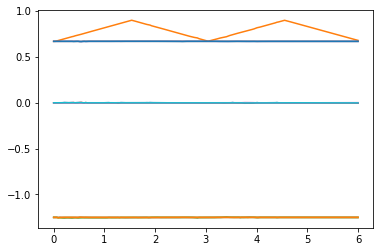

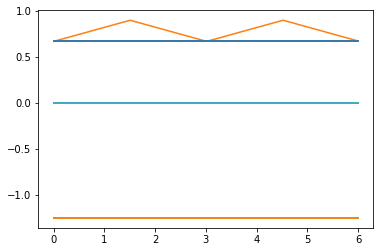

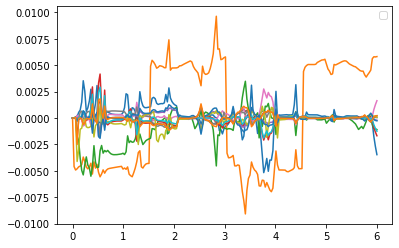

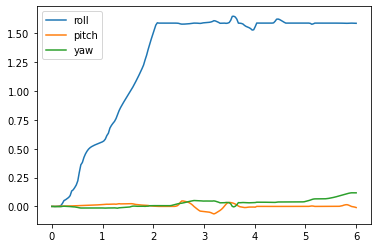

In [12]:
import matplotlib.pyplot as plt 

time = np.linspace(0, N_TIME_STEPS * N_ACTION_REPEAT * 0.001, N_TIME_STEPS)

plt.figure()
plt.plot(time, obs_hist.motor_angles)

plt.figure()
plt.plot(time, act_hist)

plt.figure()
for i in range(obs_hist.motor_angles.shape[1]):
    plt.plot(time, obs_hist.motor_angles[:,i] - act_hist[:,i])
plt.legend()

plt.figure()
for i in range(3):
    plt.plot(time, obs_hist.base_rpy[:,i], label = ['roll', 'pitch', 'yaw'][i])
plt.legend()